# Ocular Disease Recognition

---

## Introduction

### Problem Statement
Diagnosing ocular diseases is a critical healthcare activity but often suffers from delays and high costs, potentially leading to irreversible vision loss for patients.

### Who is Affected
- Patients at risk or suffering from ocular diseases
- Ophthalmologists and healthcare providers
- Medical institutions
- Medical technology companies

### Objective
This notebook aims to develop and evaluate machine learning models for the early and accurate diagnosis of ocular diseases, thereby aiding healthcare providers and improving patient outcomes.

#### Table of Contents
- **[Data Loading and Initial Checks](#Data-Loading-and-Initial-Checks)**
  - [Data Quality Check](#Data-Quality-Check)
- **[Initial EDA (Exploratory Data Analysis)](#Initial-EDA-(Exploratory-Data-Analysis))**
  - [Distribution of Patient Age](#Distribution-of-Patient-Age)
  - [Distribution of Patient Gender](#Distribution-of-Patient-Gender)
  - [Distribution of Disease Labels](#Distribution-of-Disease-Labels)
- **[Data Preprocessing](#Data-Preprocessing)**
  - [Outliers](#Outliers)
- **[Feature Engineering](#Feature-Engineering)**
  - [Baseline Models](#Baseline-Models)
- **[Model Evaluation](#Model-Evaluation)**
  - [Multiclass Classification ( Logistic Regression, Random Forest, CNN)](#Multiclass-Classification-(-Logistic-Regression,-Random-Forest,-CNN))
  - [Binary Classification (Logistic Regression, Random Forest, CNN)](#Binary-Classification-(Logistic-Regression,-Random-Forest,-CNN))
  - [Deep Learning (CNN for Binary and Multiclass)](#Deep-Learning-(CNN-for-Binary-and-Multiclass))
- **[Model Selection](#Model-Selection)**
- **[Model Training & Tuning](#Model-Training-&-Tuning)**
- **[Model Interpretation](#Model-Interpretation)**


---

## Data Loading and Initial Checks 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import zscore
import numpy as np

In [4]:
# Load the dataset
df_path = 'data/full_df.csv'
df = pd.read_csv(df_path)

# Display the first few rows of data
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [5]:
df.shape

(6392, 19)

### Data Quality Check 
We are checking the data for any quality issues such as missing or inconsistent data. 

In [6]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()

missing_values

ID                           0
Patient Age                  0
Patient Sex                  0
Left-Fundus                  0
Right-Fundus                 0
Left-Diagnostic Keywords     0
Right-Diagnostic Keywords    0
N                            0
D                            0
G                            0
C                            0
A                            0
H                            0
M                            0
O                            0
filepath                     0
labels                       0
target                       0
filename                     0
dtype: int64

There are no missing values in any columns! This is great news and potentially indicates good data quality.
<br> It also eliminates the need for imputation or deletion of missing records at the stage.
<br> It is also good to note that the the disease labels are already one-hot encoded which may help with the machine learning algorithms in the future. 
<br>
<br> Another column of note is the 'filepath'. This field is indicating where the data was stored when the initial data collection took place. This will need to be updated or removed all together. 

## Initial EDA (Exploratory Data Analysis)
---


Let's start by taking a look at the distribution of the genders and ages of the patients. 

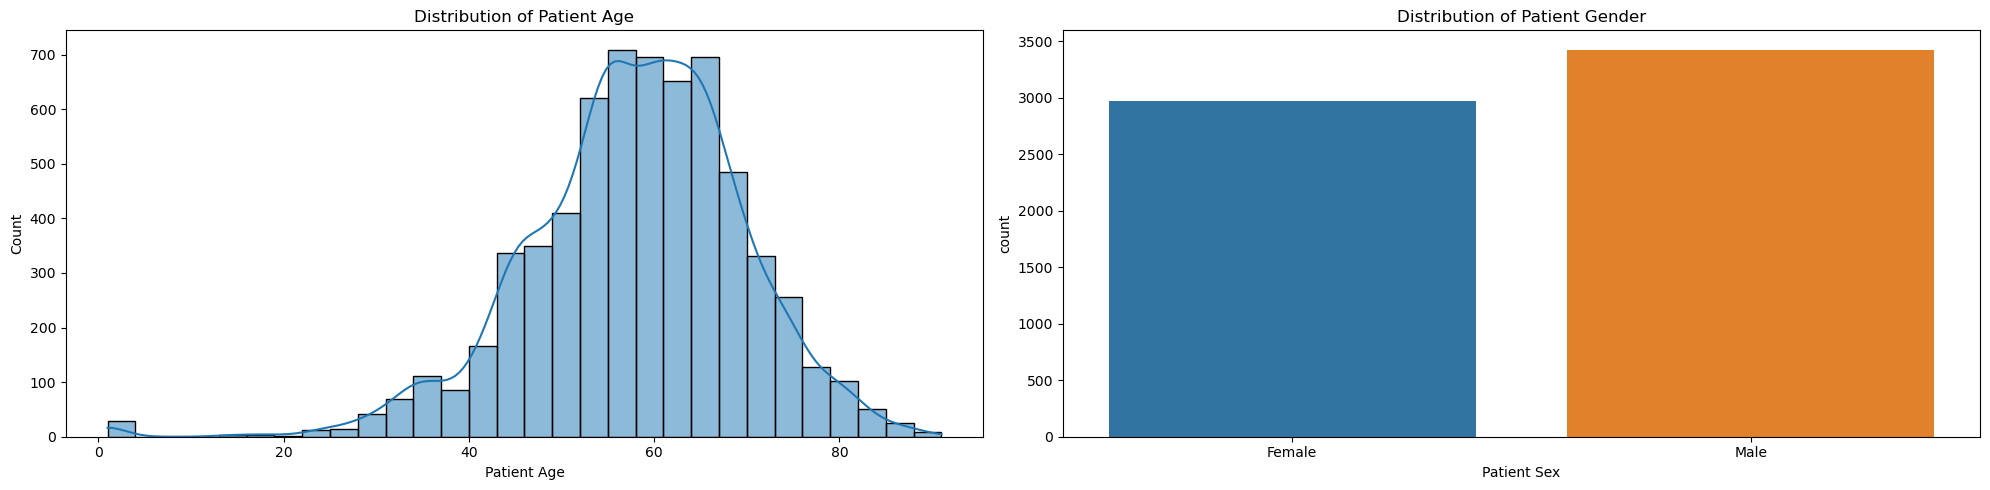

In [7]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 5))

# Plot the age distribution
plt.subplot(1, 2, 1)
sns.histplot(df['Patient Age'], bins=30, kde=True)
plt.title('Distribution of Patient Age')

# Plot the gender distribution
plt.subplot(1, 2, 2)
sns.countplot(x='Patient Sex', data=df)
plt.title('Distribution of Patient Gender')

plt.tight_layout()
plt.show()

#### Distribution of Patient Age: 
The age distribution is relatively broad, covering a range of ages. Most patients are in their 40s to 60s, but there are also quite a few younger and older patients with a few outliers at age 1.

#### Distribution of Patient Gender: 
The number of male and female patients seems fairly balanced, which is good for avoiding gender bias in the analyses.

Next let's take a look at the distribution of diseases in the dataset.

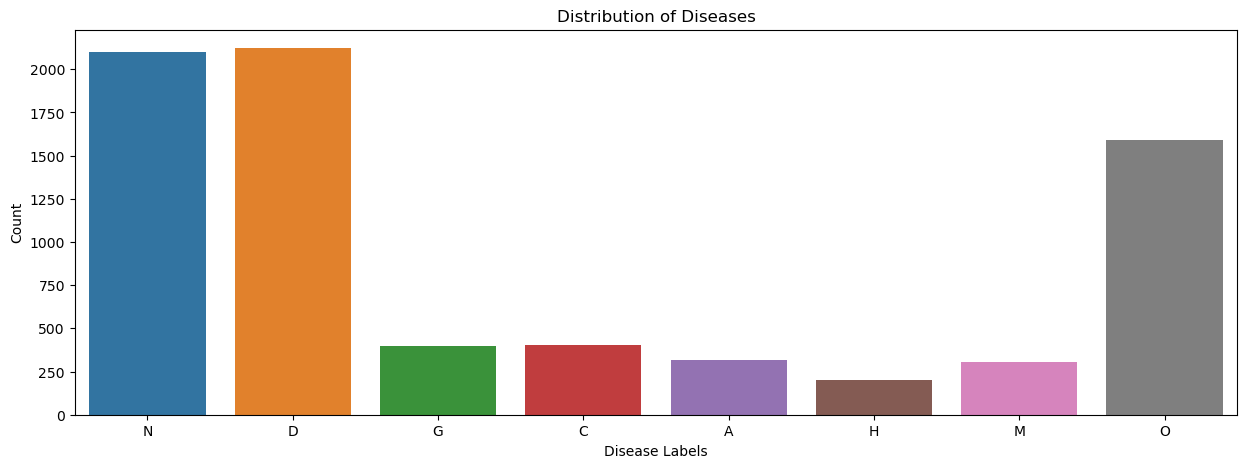

In [8]:
# Plot the distribution of labels
label_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
label_counts = df[label_columns].sum()

plt.figure(figsize=(15, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Diseases')
plt.xlabel('Disease Labels')
plt.ylabel('Count')
plt.show()

In [9]:
# Calculate the proportion of each disease label in the dataset
total_records = len(df)
label_proportions = (df[label_columns].sum() / total_records) * 100
label_proportions

N    32.869212
D    33.213392
G     6.210889
C     6.289111
A     4.990613
H     3.175845
M     4.787234
O    24.843554
dtype: float64

#### Distribution of Disease Labels: 

- Normal (N): 32.87%
- Diabetes (D): 33.21%
- Glaucoma (G): 6.21%
- Cataract (C): 6.29%
- Age-related Macular Degeneration (A): 4.99%
- Hypertension (H): 3.18%
- Pathological Myopia (M): 4.79%
- Other diseases/abnormalities (O): 24.84%

From the proportions, it's evident that there is some imbalance in the dataset:
- 'Normal' and 'Diabetes' constitute the majority of the dataset, each making up over 30% of the records.
- Diseases like 'Hypertension', 'Age-related Macular Degeneration','Glaucoma','Cataract' and 'Pathological Myopia' make up less than 7% each.
- 'Other diseases/abnormalities' havew moderate representation at 25%.

This imbalance will need to be accounted for during model training by using metrics that are sensitive to imbalance.

Let's dive a little deeper into the distributions of the diseases across ages. 

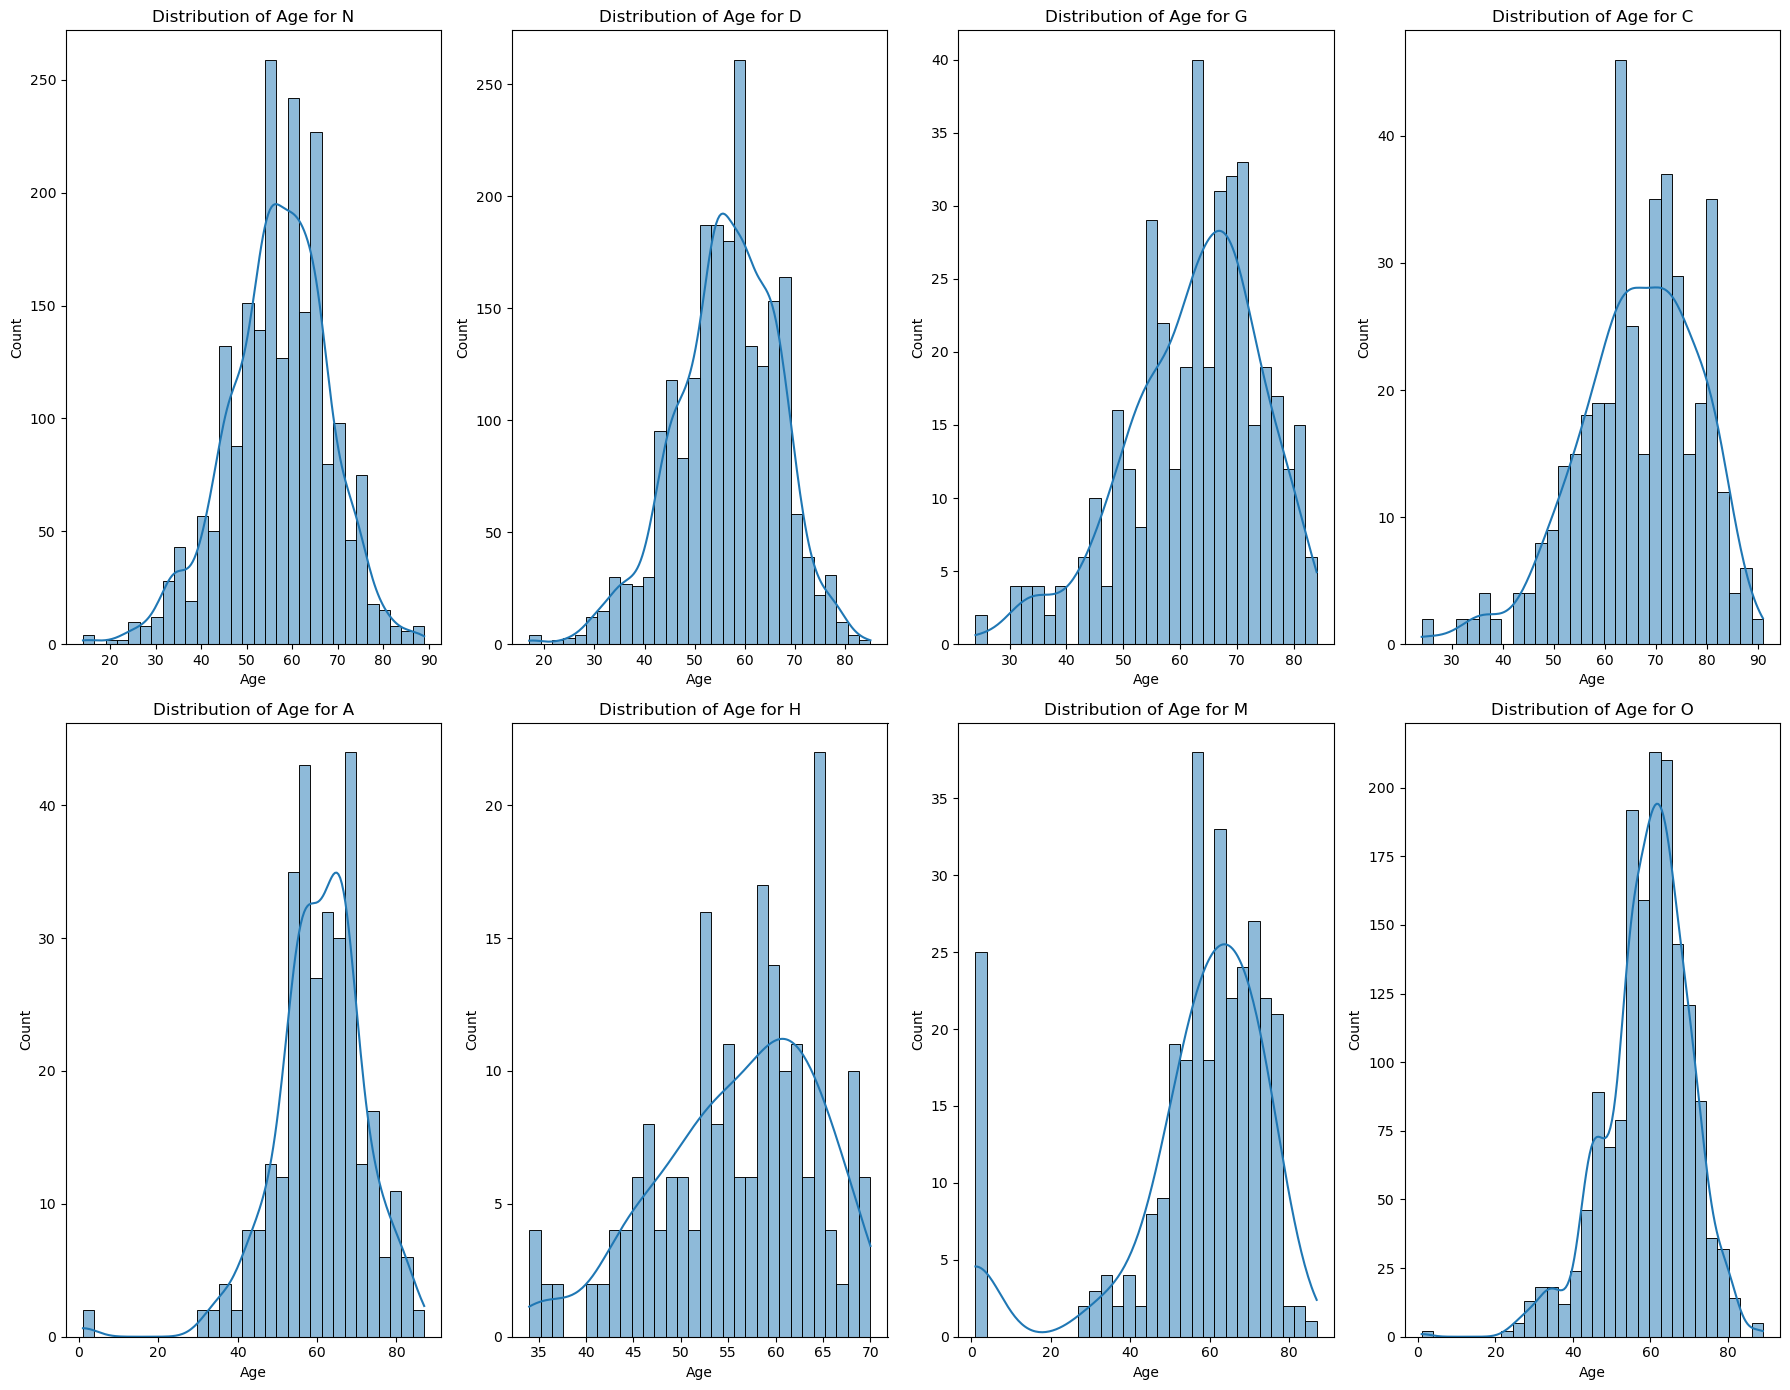

In [10]:
# Set up the matplotlib figure
plt.figure(figsize=(18, 14))

# Loop through each disease to plot its distribution across ages
for i, label in enumerate(label_columns):
    plt.subplot(2, 4, i+1)
    sns.histplot(df[df[label] == 1]['Patient Age'], bins=30, kde=True)
    plt.title(f'Distribution of Age for {label}')
    plt.xlabel('Age')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

#### Disease Distribution Across Ages: 
- Normal (N): Appears to be fairly evenly distributed across ages, with a peak around the 50-60 age range.
- Diabetes (D): Predominantly found in middle-aged to older individuals, roughly from 40 to 70 years of age.
- Glaucoma (G): Mainly affects older individuals, particularly those above 50 years of age.
- Cataracts (C): Most common in older individuals, especially those above 60.
- Age-related Macular Degeneration (A): Almost exclusively affects individuals above 50, peaking around 60-70.
- Hypertension (H): Distribution is somewhat similar to that of Diabetes, mainly affecting those in the 40-70 age range.
- Pathological Myopia (M): Has a large outlier at age 1 with the majority of patients being over 50.
- Other diseases/abnormalities (O): Distributed across a broad age range but seems to peak around 40-60.

Here we can check out outliers in the age category. 

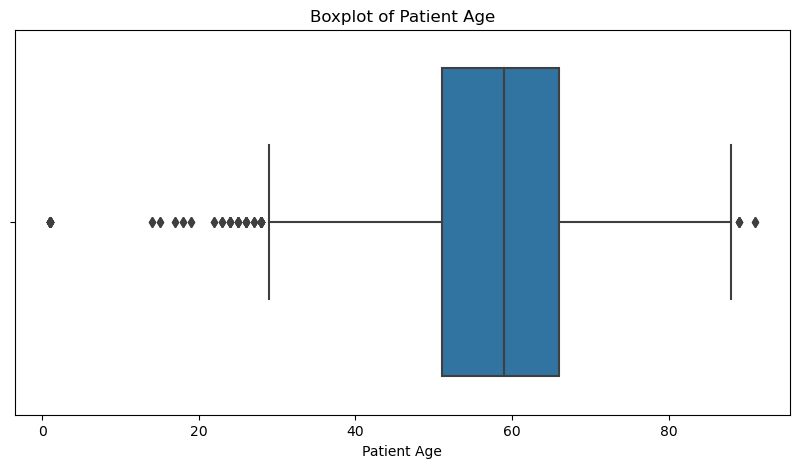

count    6392.000000
mean       57.857947
std        11.727737
min         1.000000
25%        51.000000
50%        59.000000
75%        66.000000
max        91.000000
Name: Patient Age, dtype: float64

In [11]:
# Identify potential outliers in 'Patient Age'
plt.figure(figsize=(10, 5))

# Create a boxplot for 'Patient Age'
sns.boxplot(x='Patient Age', data=df)
plt.title('Boxplot of Patient Age')
plt.show()

# Calculate summary statistics for 'Patient Age'
age_summary_stats = df['Patient Age'].describe()
age_summary_stats

#### Outliers in Patient Age:
- Minimum Age: The minimum age is 1, which is seems lower than the typical age range for most ocular diseases. This could be because special cases come to the hospitals to be treated and are included in the dataset while the average child does not have ocuilar issues. 
- Maximum Age: The maximum age is 91, which falls within a plausible range for ocular diseases, especially those that are age-related.
- Interquartile Range: Most patients are between the ages of 51 and 66, with a median age of 59.
- Standard Deviation: The standard deviation is approximately 11.73 years, indicating a relatively broad spread around the mean age of approximately 57.86 years.

Let's take a look at diseases across genders. 

In [12]:
# Count of gender for each disease label
gender_disease_count = df.groupby('Patient Sex')[label_columns].sum().reset_index()
gender_disease_count

,Patient Sex,N,D,G,C,A,H,M,O
0,Female,927,940,167,234,146,76,198,789
1,Male,1174,1183,230,168,173,127,108,799


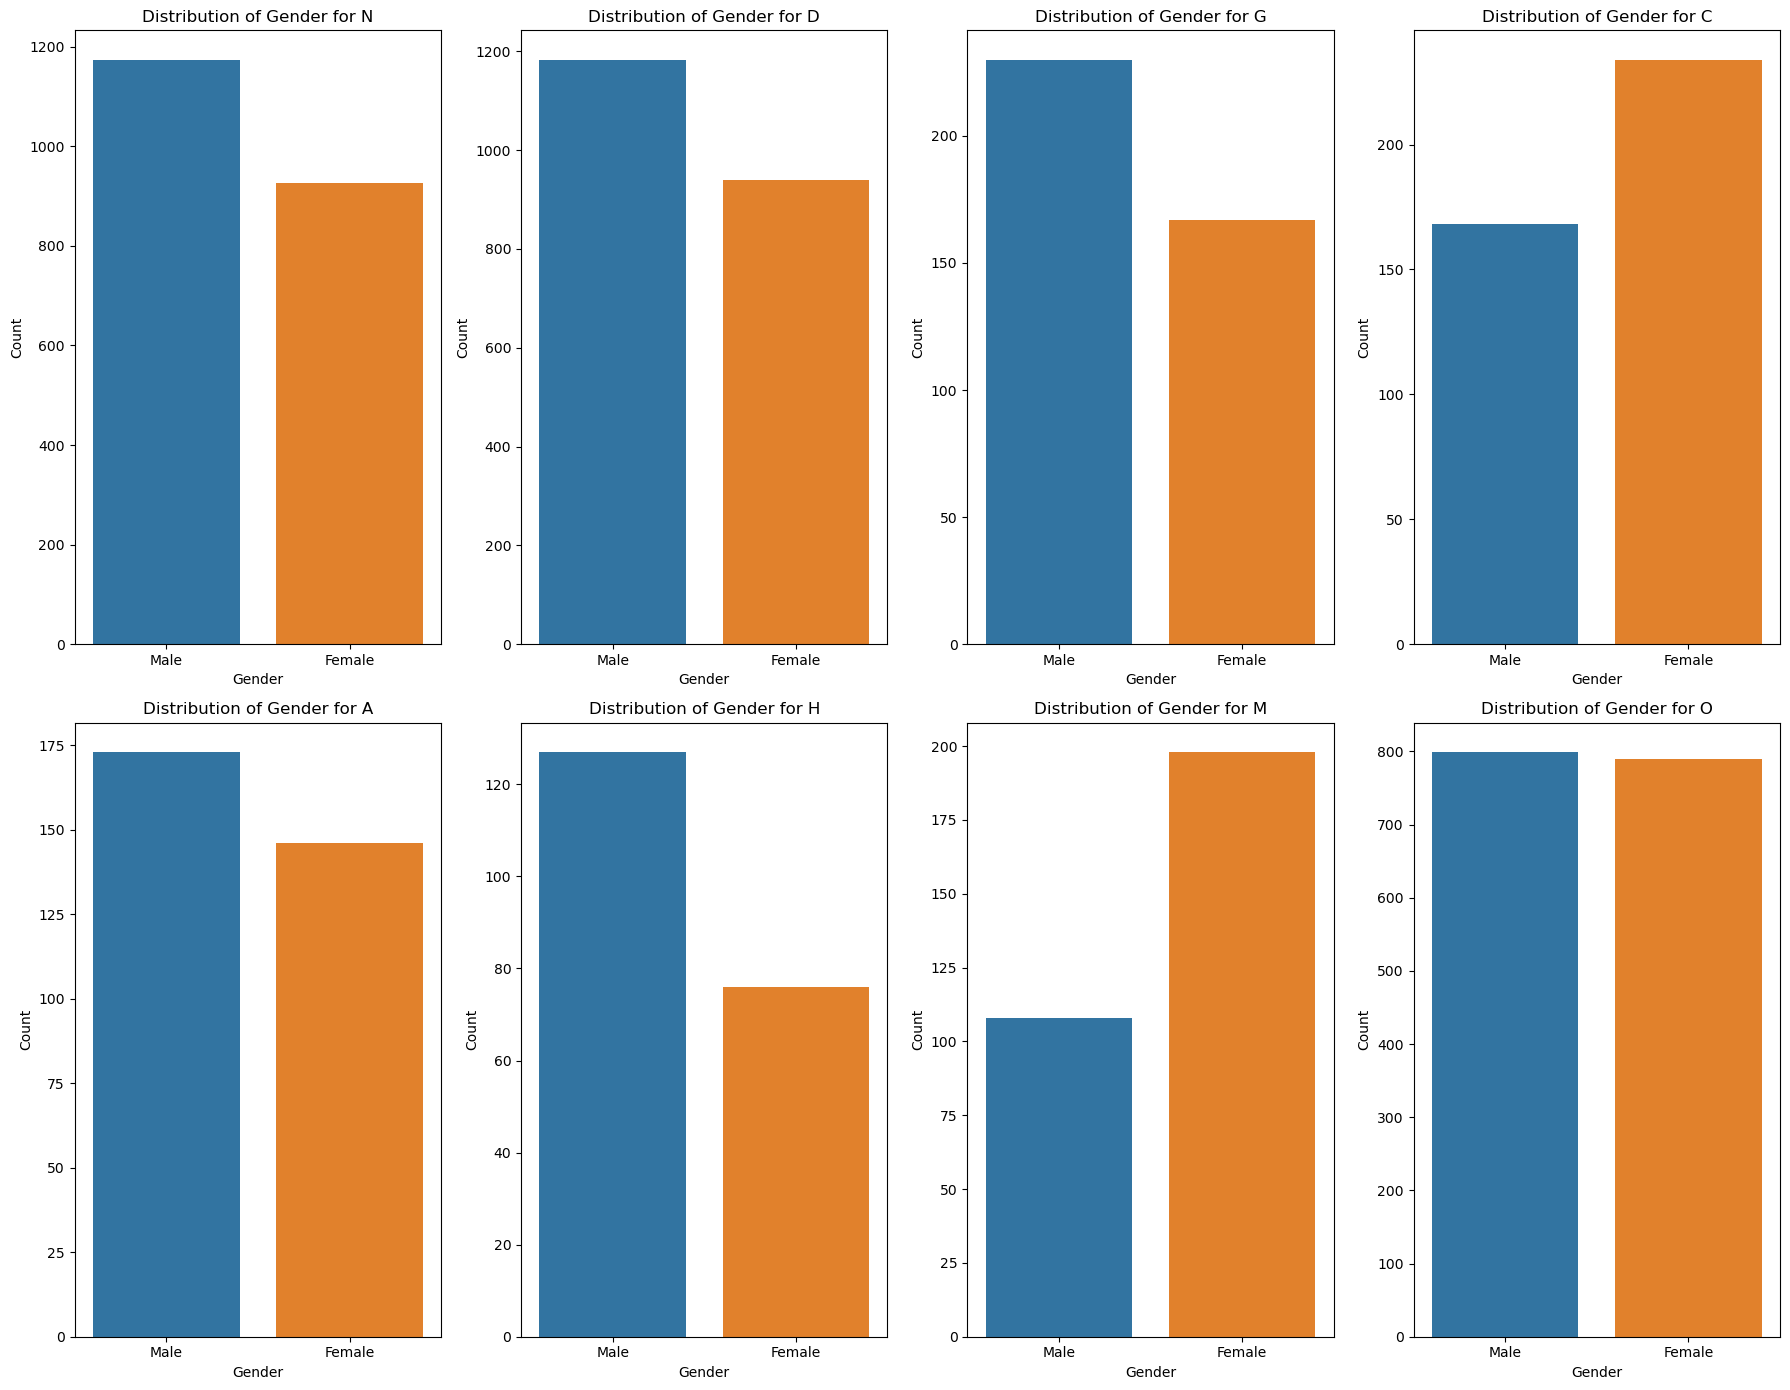

In [13]:
# Define the labels
label_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Sort the gender categories so that Male and Female are in the same position for each plot.
df['Patient Sex'] = pd.Categorical(df['Patient Sex'], categories=['Male', 'Female'], ordered=True)

# Set up the matplotlib figure
plt.figure(figsize=(18, 14))

# Loop through each disease label to plot its distribution across genders
for i, label in enumerate(label_columns):
    plt.subplot(2, 4, i+1)
    sns.countplot(x='Patient Sex', data=df[df[label] == 1], order=['Male', 'Female'])
    plt.title(f'Distribution of Gender for {label}')
    plt.xlabel('Gender')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

#### Disease Distribution Across Genders:
- Normal (N): Male - 1174, Female - 927
- Diabetes (D): Male - 1183, Female - 940
- Glaucoma (G): Male - 230, Female - 167
- Cataract (C): Male - 168, Female - 234
- Age-related Macular Degeneration (A): Male - 173, Female - 146
- Hypertension (H): Male - 127, Female - 76
- Pathological Myopia (M): Male - 108, Female - 198
- Other diseases/abnormalities (O): Male - 799, Female - 789
##### Note: The scales of the y-axis (count) vary from chart to chart

Next we will see if there are any co-occurrence between diseases. 

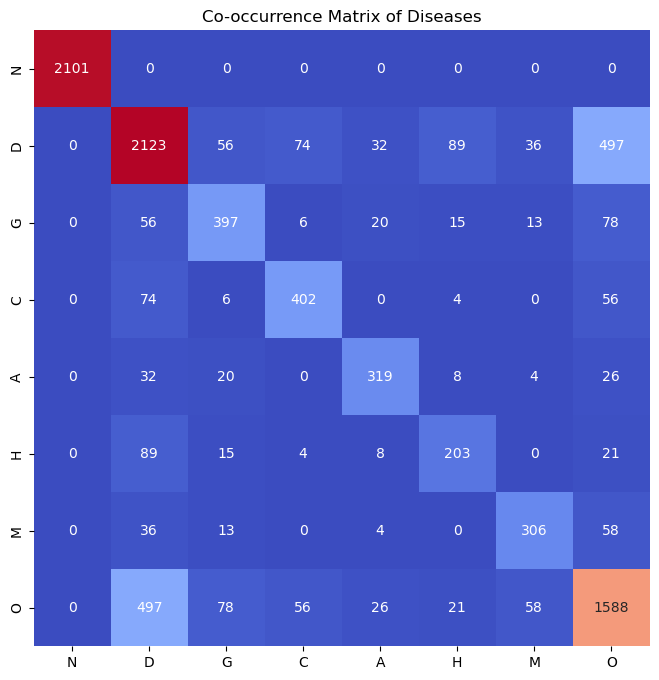

In [14]:
# Calculate co-occurrence matrix for the disease labels
cooccurrence_matrix = df[label_columns].T.dot(df[label_columns])

# Plot the co-occurrence matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cooccurrence_matrix, annot=True, fmt='d', cmap='coolwarm', square=True, cbar=False)
plt.title('Co-occurrence Matrix of Diseases')
plt.show()

#### Co-occurrence Among Diseases:
- Normal (N): As expected, the 'Normal' label has no co-occurance with any other categories, indicating quality of data. 
- Diabetes (D): Seems to have the most prevelant co-occurance across all diseases suggesting that patients diagnosed with Diabetes often have other ocular abnormalities as well.
- Glaucoma (G): A moderate level of co-occurrence across all diseases, indicating that Glaucoma is often accompanied by other ocular conditions.
- Hypertension (H) and Other (O): A small relation here, perhaps hypertension is a good indactor of poor eye health.


Let's do the same across genders. 

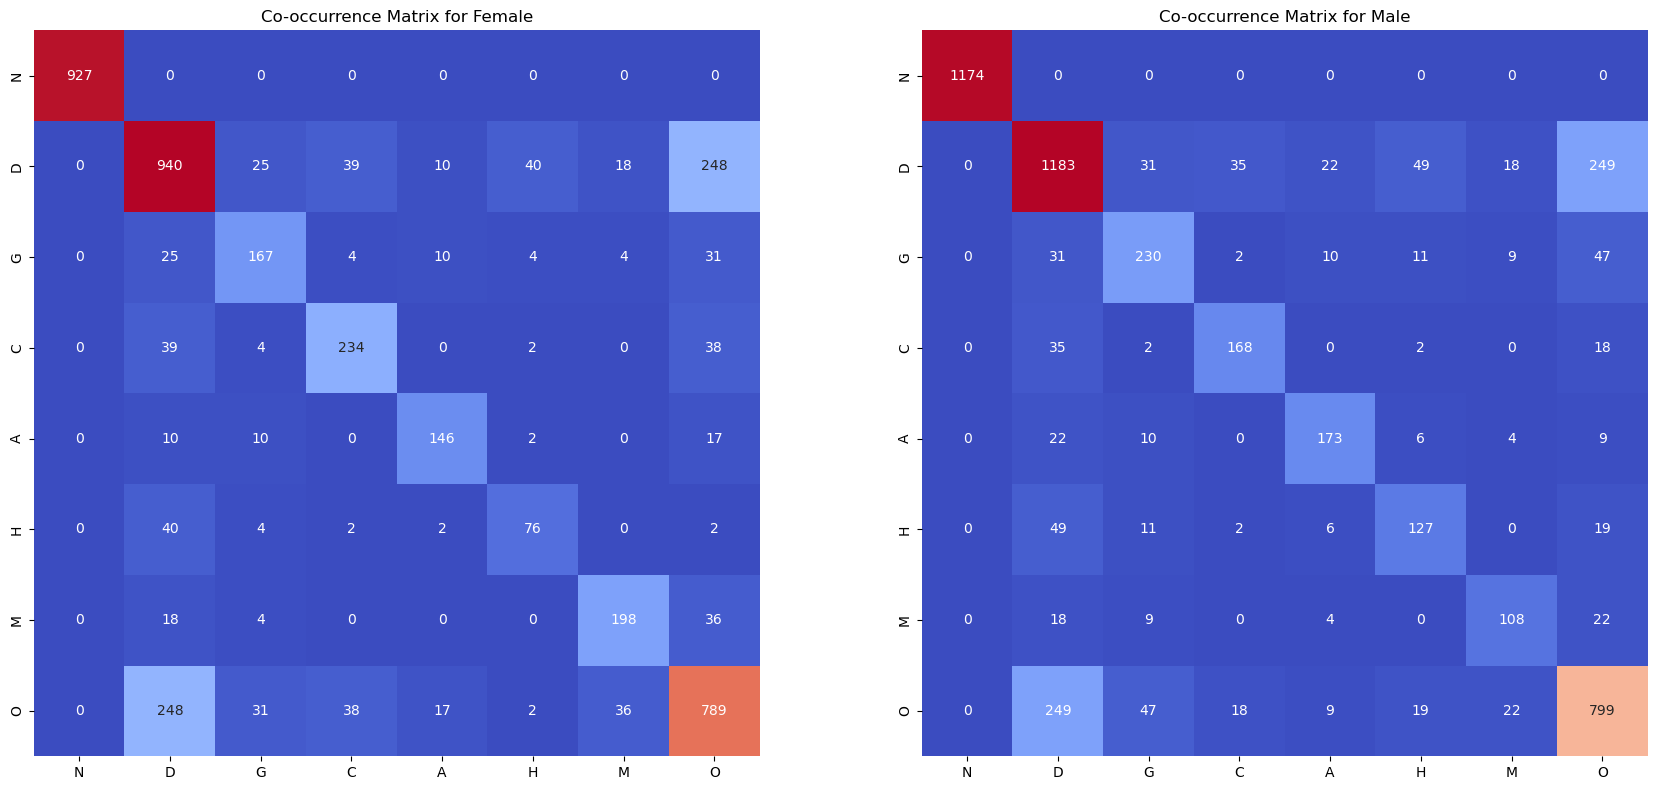

In [15]:
# Calculate and plot the co-occurrence matrix for each gender
genders = df['Patient Sex'].unique()

# Set up the matplotlib figure
fig, axes = plt.subplots(1, len(genders), figsize=(18, 8))

for i, gender in enumerate(genders):
    gender_df = df[df['Patient Sex'] == gender]
    cooccurrence_matrix_gender = gender_df[label_columns].T.dot(gender_df[label_columns])
    
    sns.heatmap(cooccurrence_matrix_gender, annot=True, fmt='d', cmap='coolwarm', square=True, cbar=False, ax=axes[i])
    axes[i].set_title(f'Co-occurrence Matrix for {gender}')

plt.tight_layout()
plt.show()

#### Gender Varying Co-occurrence Among Diseases:
- Diabetes (D): Relatively The same across genders and diseases with a note that Age-related Macular Degeneration (A) is double in men over women who also have diabetes. 
- Glaucoma (G): Along with Hypertension (H) seems to be found more in men than women. 
- Cataracts (C): Paired with Other diseases/abnormalities (O) is much higher in women. This may be because women generally live longer than men and Cataracts is an age related disease. 
- Age-related Macular Degeneration (A): Same as above with Other diseases/abnormalities (O). 
- Hypertension (H): Seems to display more in men who have Other diseases/abnormalities (O). This could be a valuable indicator in men. 
- Pathological Myopia (M): Uniform across all diseases and genders. 

Next we can take a look at correlation of each disease with age. 

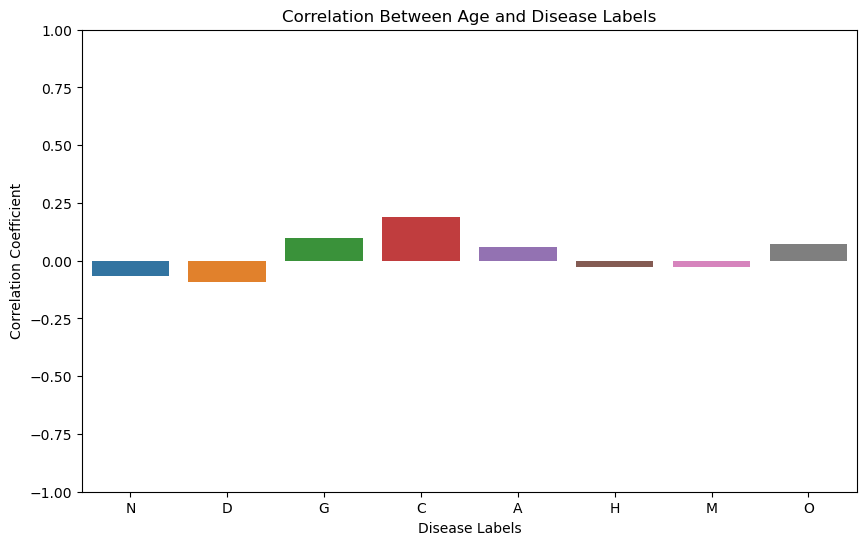

N   -0.066672
D   -0.091023
G    0.100070
C    0.190199
A    0.058467
H   -0.026488
M   -0.025278
O    0.071769
Name: Patient Age, dtype: float64

In [16]:
# Calculate the correlation between Patient Age and each disease
age_disease_correlation = df[label_columns + ['Patient Age']].corr()['Patient Age'].drop('Patient Age')

# Plot the correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=age_disease_correlation.index, y=age_disease_correlation.values)
plt.title('Correlation Between Age and Disease Labels')
plt.xlabel('Disease Labels')
plt.ylabel('Correlation Coefficient')
plt.ylim(-1, 1)
plt.show()

age_disease_correlation

#### Correlation Between Age and Disease Labels:
- Normal (N): −0.067
- Diabetes (D): −0.091
- Glaucoma (G): 0.100
- Cataract (C): 0.190
- Age-related Macular Degeneration (A): 0.058
- Hypertension (H): −0.026
- Pathological Myopia (M): −0.025
- Other diseases/abnormalities (O): 0.072

Key Points:
- Cataract (C) has the highest positive correlation with age (0.190), which aligns with the disease generally affecting older individuals.
- Glocoma (G) has a positive correlation of 0.100 indicating that as one gets older they are more likely to develope this disease. 
- Diabetes (D) has a negative correlations of −0.091 respectively, suggesting this is slightly less common in older age groups or perhaps a shorter life span of individuals with these diseases. 
- Normal (N) also has a negative correlation indicating that as oane gets older they are more likely to develop an ocular disease. 
- Most correlations are close to zero, indicating a weak linear relationship between age and these diseases in this particular dataset.

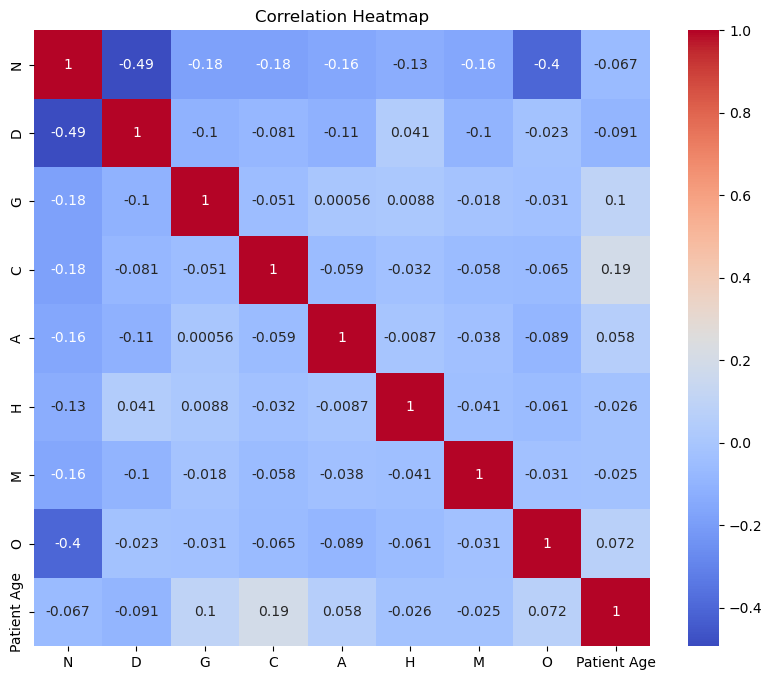

In [17]:
# Calculate the correlation matrix for all numerical and boolean columns
correlation_matrix = df[label_columns + ['Patient Age']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Heatmap')
plt.show()

#### Correlation Heatmap:
- Cataract (C): Shows the highest positive correlation with age, aligning with our earlier findings.
- Diabetes (D) and Normal (N): These have negative correlations with age, which also aligns with earlier observations.
- Across Disease Correlations: Most diseases show low correlation with each other this gives us more context to our co-occurrence matrix we examined earlier.

Next we will check out the Chi<sup>2</sup> contingency and correlation coefficients between age and disease. 

In [18]:
from scipy.stats import chi2_contingency

# Make a dictionary to store the Chi-Squared test
chi2_results_age = {}

# Loop through each disease to do the Chi-Squared test
for label in label_columns:
    contingency_table = pd.crosstab(df['Patient Age'], df[label])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    chi2_results_age[label] = p_value

# Display the p-values
chi2_results_age

{'N': 5.682176075585225e-17,
 'D': 6.634120004778226e-27,
 'G': 8.73437336855168e-25,
 'C': 6.260635079125064e-83,
 'A': 0.0009636461280752949,
 'H': 0.14517050576374413,
 'M': 5.5844331727773814e-83,
 'O': 4.424470116213503e-09}

### Age Chi-Squared Tests:
All p-values are less than 0.05, with the exception of Hypertension, indicating that the correlation between Patient Age and most of the diseases are statistically significant.

In [19]:
from scipy.stats import pearsonr

# Make a dictionary to store the correlation coefficient 
pearson_results = {}

# Loop through each disease to do the correlation test
for label in label_columns:
    correlation, p_value = pearsonr(df['Patient Age'], df[label])
    pearson_results[label] = p_value

# Display the p-values
pearson_results

{'N': 9.538686480712373e-08,
 'D': 3.0772018094725127e-13,
 'G': 1.0647721794880347e-15,
 'C': 3.9035765715681624e-53,
 'A': 2.9030615431087215e-06,
 'H': 0.03420473605771399,
 'M': 0.043288260399383556,
 'O': 9.234409038589165e-09}

### Age Correlation Coefficients:
All p-values are less than 0.05, indicating that the correlation between Patient Age and each of the diseases are statistically significant. 
<br>This gives more confidence to the correlation observations made earlier.

Let's take a look at the gender Chi2 next. 

In [20]:
from scipy.stats import chi2_contingency

# Make a dictionary to store the Chi-Squared test
chi2_results = {}

# Loop through each disease to do the Chi-Squared test
for label in label_columns:
    contingency_table = pd.crosstab(df['Patient Sex'], df[label])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    chi2_results[label] = p_value

# Display the p-values
chi2_results

{'N': 0.010292287752460168,
 'D': 0.015917376297791754,
 'G': 0.08015363218695276,
 'C': 1.3061486158980793e-06,
 'A': 0.8518602358305498,
 'H': 0.011088090890330268,
 'M': 7.533737221638382e-11,
 'O': 0.002993815591240188}

### Gender Chi-Squared Tests:
Normal (N): p=0.01 - Statistically significant difference in distribution between genders.
<br>Diabetes (D): p=0.016 - Statistically significant difference in distribution between genders.
<br>Glaucoma (G): p=0.08 - No statistically significant difference in distribution between genders.
<br>Cataract (C):p=1.31×10<sup>−6</sup> - Highly significant difference in distribution between genders.
<br>Age-related Macular Degeneration (A): p=0.85 - No statistically significant difference in distribution between genders.
<br>Hypertension (H): p=0.011 - Statistically significant difference in distribution between genders.
<br>Pathological Myopia (M): p=7.53×10<sup>−11</sup> - Highly significant difference in distribution between genders.
<br>Other diseases/abnormalities (O): p=0.003 - Statistically significant difference in distribution between genders.

## Data Preprocessing

### Outliers 

Let's take a look at those outliers mentioned before. 

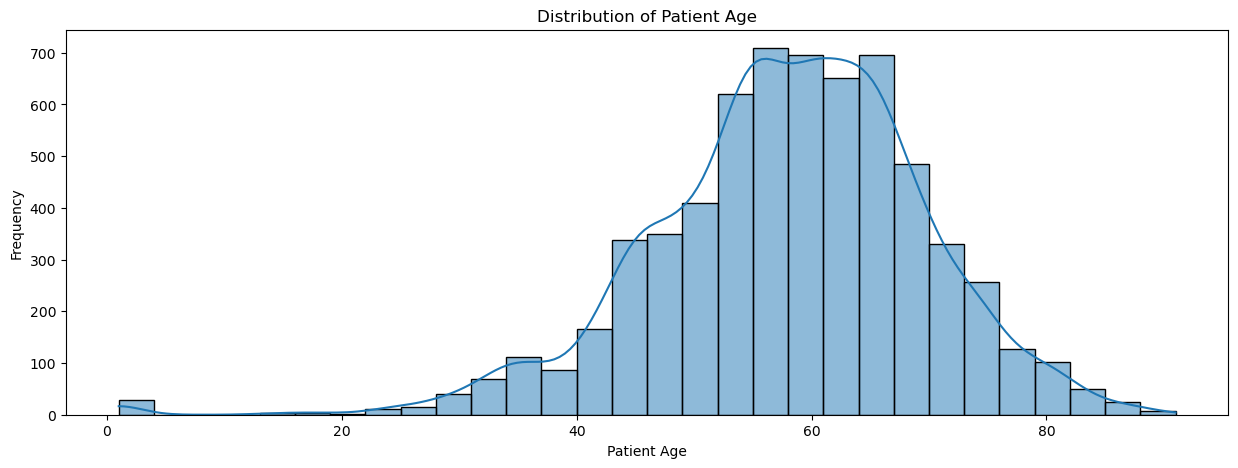

In [24]:
# Plotting the distribution of 'Patient Age'
plt.figure(figsize=(15, 5))
sns.histplot(df['Patient Age'], kde=True, bins=30)
plt.title('Distribution of Patient Age')
plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.show()

The distribution of age shows a concentration of ages around the 50-70 range. There are also instances at the lower end which appear to be outliers.

We can take a look at the Z-Score to determine if there are any outliers in the data

In [25]:
# Calculate Z-scores
df['Age_Zscore'] = zscore(df['Patient Age'])

# Identify outliers
outliers = df[(df['Age_Zscore'].abs() > 3)]

# Count and display outliers
num_outliers = len(outliers)
print(f'There are {num_outliers} outside of 3 standard deviations.')
outliers.sample(5)

There are 40 outside of 3 standard deviations.


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename,Age_Zscore
1219,1564,1,Female,1564_left.jpg,1564_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",1564_right.jpg,-4.848539
5409,3098,22,Female,3098_left.jpg,3098_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3098_left.jpg,-3.057772
1260,1617,1,Female,1617_left.jpg,1617_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",1617_right.jpg,-4.848539
4439,1603,1,Female,1603_left.jpg,1603_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",1603_left.jpg,-4.848539
1013,1242,1,Female,1242_left.jpg,1242_right.jpg,chorioretinal atrophy,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1242_right.jpg,-4.848539


It seems like there are 40 outliers outside of the three standard deviation threshold. We could drop these as there are so few or leave them and be carefull with the models we are chosing to ensure they are not impacted greatly by these outliers. 

I was specifically interested in the distribution of age across the Myopia feature, so we will take a look at this next.

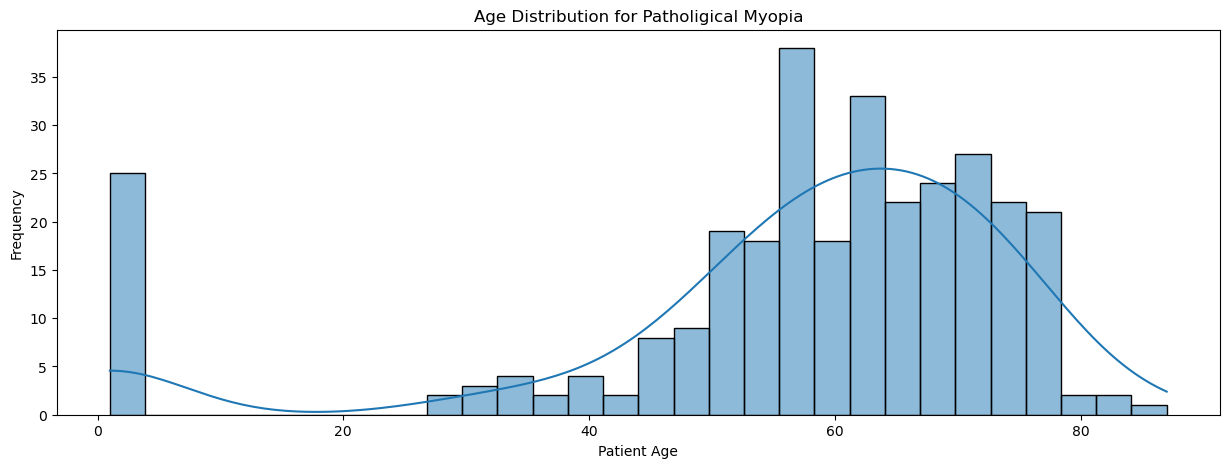

In [26]:
# Filter the dataset to only include Pathological Myopia 
df_m_disease = df[df['M'] == 1].copy()

# Plot the age distribution
plt.figure(figsize=(15, 5))
sns.histplot(df_m_disease['Patient Age'], kde=True, bins=30)
plt.title('Age Distribution for Patholigical Myopia')
plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.show()

Looks like a large spike in outliers, so let's see how it impacts this disease. 

In [27]:
# Calculate basic statistics for the Myopia age distribution
basic_stats_m = df_m_disease['Patient Age'].describe()
basic_stats_m

count    306.000000
mean      56.535948
std       19.666073
min        1.000000
25%       52.000000
50%       62.000000
75%       69.000000
max       87.000000
Name: Patient Age, dtype: float64

In [28]:
# Calculate Z-scores for Age in Myopia 
df_m_disease['Age_Zscore_M'] = zscore(df_m_disease['Patient Age'])

# Identify outliers
outliers_m = df_m_disease[df_m_disease['Age_Zscore_M'].abs() > 3]

# Count and display outliers
num_outliers_m = len(outliers_m)
outliers_m.head(), num_outliers_m

(Empty DataFrame
 Columns: [ID, Patient Age, Patient Sex, Left-Fundus, Right-Fundus, Left-Diagnostic Keywords, Right-Diagnostic Keywords, N, D, G, C, A, H, M, O, filepath, labels, target, filename, Age_Zscore, Age_Zscore_M]
 Index: []
 
 [0 rows x 21 columns],
 0)

This is surprising to me. It seems as though there are no outliers outside of the 3 standard deviation threshold.

Given that these data points are included in this dataset I am going to conclude (for now) that they have significant medical implications and will leave them in this dataset for the time being. I have a feeling that any new data point with an age of 1 may be classified as Pathologically Myopic, so this will have to be considered as we evaluate models. 

## Feature Engineering 

Let's run some baseline models to get a get a better understanding of our data. 

First, let's split the data with each disease evenly distributed in the train and test sets.  

In [29]:
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename,Age_Zscore
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,0.950134
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,-0.073161
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,-1.352280
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg,-0.414260
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg,-0.670083


In [30]:
# Check the distribution of disease labels
label_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
label_distribution = df[label_columns].sum().sort_values(ascending=False)

label_distribution

D    2123
N    2101
O    1588
C     402
G     397
A     319
M     306
H     203
dtype: int64

The distribution of disease labels shows varying counts for each label:

Diabetes (D): 2123
<br>Normal (N): 2101
<br>Other (O): 1588
<br>Cataract (C): 402
<br>Glaucoma (G): 397
<br>Age-related Macular Degeneration (A): 319
<br>Pathological Myopia (M): 306
<br>Hypertension (H): 203

Since some of the images are labeled with multiple diseases we will have to prioritize splitting based on frequency of occurence. This means that the least common diseases will be prioritized to ensure a proper distribution. 

In [31]:
#Find the most significant label based on the frequency
def find_significant_label(row):
    labels_present = [label for label in label_columns if row[label] == 1]
    if not labels_present:
        return np.nan
    return min(labels_present, key=lambda x: label_distribution[x])

# Apply the significant label function
df['Significant_Label'] = df.apply(find_significant_label, axis=1)

In [32]:
# Sanity check 
df[['Significant_Label'] + label_columns].sample(5)

,Significant_Label,N,D,G,C,A,H,M,O
1104,G,0,1,1,0,0,0,0,0
3309,O,0,0,0,0,0,0,0,1
5440,N,1,0,0,0,0,0,0,0
3618,O,0,1,0,0,0,0,0,1
3940,O,0,0,0,0,0,0,0,1


Let's see how the labels were sorted

In [33]:
# Count of each significant label
significant_label_distribution = df['Significant_Label'].value_counts().sort_values(ascending=False)
significant_label_distribution

Significant_Label
N    2101
D    1376
O    1358
C     392
G     349
A     307
M     306
H     203
Name: count, dtype: int64

A quick visual of the distribution. 

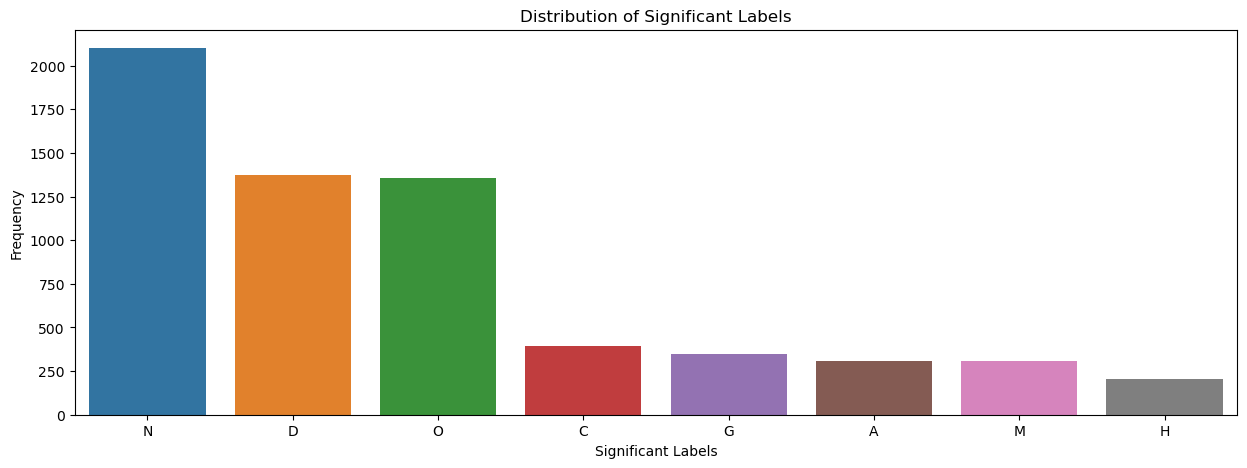

In [34]:
# Count the distribution of each
significant_label_distribution = df['Significant_Label'].value_counts().reset_index()
significant_label_distribution.columns = ['Significant_Label', 'Count']

# plot a bar chart
plt.figure(figsize=(15, 5))
sns.barplot(x='Significant_Label', y='Count', data=significant_label_distribution)
plt.xlabel('Significant Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Significant Labels')
plt.show()

Below is the original frequency distribution for reference. 

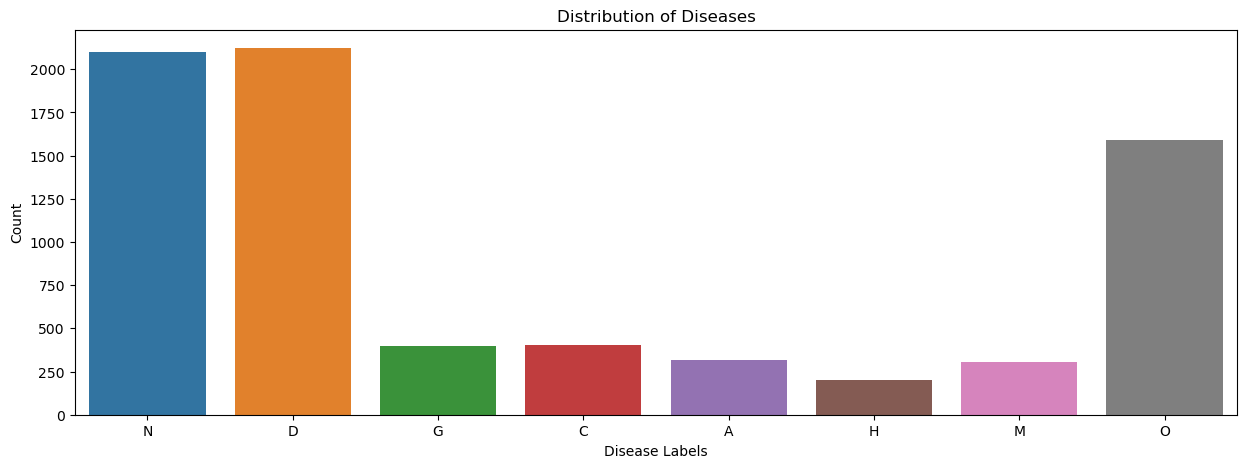

In [35]:
# Plot the Original distribution
label_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
label_counts = df[label_columns].sum()

plt.figure(figsize=(15, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Diseases')
plt.xlabel('Disease Labels')
plt.ylabel('Count')
plt.show()

The new distribution should ensure that we have an accurate representation across all of the diseases. 

This will slightly help the class imbalance but this will still have to be addressed in the future.

Let's split data into training and test sets. 

In [36]:
# Import the library
from sklearn.model_selection import train_test_split

In [37]:
# Split the data into training and test sets using stratified sampling
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Significant_Label'], random_state=86)

# Check the distribution of labels in the training set
train_label_distribution = train_df[label_columns].sum().sort_values(ascending=False)

# Check the distribution of labels in the test set
test_label_distribution = test_df[label_columns].sum().sort_values(ascending=False)

train_label_distribution, test_label_distribution

(D    1696
 N    1681
 O    1270
 C     321
 G     317
 A     254
 M     245
 H     162
 dtype: int64,
 D    427
 N    420
 O    318
 C     81
 G     80
 A     65
 M     61
 H     41
 dtype: int64)

Let's split the images to match the sets. 

In [38]:
import shutil
import os

# Create directories for training and test images
os.makedirs("data/training_images/", exist_ok=True)
os.makedirs("data/test_images/", exist_ok=True)

# Function to move images
def move_images(df, destination_folder):
    for filename in df['filename']:
        source = os.path.join("data/preprocessed_images/", filename)
        destination = os.path.join(destination_folder, filename)
        shutil.copy(source, destination)

# Move training images
move_images(train_df, "data/training_images/")

# Move test images
move_images(test_df, "data/test_images/")

Sanity Check

In [39]:
def output_image_counts(df, folder_path):
    # Count the number of unique filenames in the DataFrame
    df_count = df['filename'].nunique()
    
    # Count the number of image files in the folder
    folder_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    
    print(f"DataFrame has {df_count} unique images.")
    print(f"{folder_count} images found in {folder_path}.")

# Output the count for the training set
output_image_counts(train_df, "data/training_images/")

# Output the count for the test set
output_image_counts(test_df, "data/test_images/")

DataFrame has 5113 unique images.
5113 images found in data/training_images/.
DataFrame has 1279 unique images.
1279 images found in data/test_images/.


Looking good. We split the data and kept the distribution of disease types intact. 
<br> Next we can flatten the images. 

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from PIL import Image

# Function to flatten and preprocess images
def flatten_images(image_paths, img_size=(150, 150)):
    flattened_images = []
    for image_path in image_paths:
        # Open and resize image
        image = Image.open(image_path).resize(img_size)
        
        # Convert to numpy array and normalize
        image_array = np.array(image) / 255.0
        
        # Flatten the image to 1D array
        flat_image_array = image_array.flatten()
        
        # Append to list
        flattened_images.append(flat_image_array)
    
    return np.array(flattened_images)

In [41]:
# Generate full image paths
train_image_paths = ["data/training_images/" + fname for fname in train_df['filename']]
test_image_paths = ["data/test_images/" + fname for fname in test_df['filename']]

In [42]:
# Flatten images and normalize
X_train_flat = flatten_images(train_image_paths, img_size=(64, 64))  # Reduced size for computational efficiency
X_test_flat = flatten_images(test_image_paths, img_size=(64, 64))   # Reduced size for computational efficiency

# Use 'Significant_Label' for labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['Significant_Label'])
y_test = label_encoder.transform(test_df['Significant_Label'])

Checking to see if the labels were added. 

In [43]:
train_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,A,H,M,O,filepath,labels,target,filename,Age_Zscore,Significant_Label
4857,2492,43,Male,2492_left.jpg,2492_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",2492_left.jpg,-1.267006,N
4162,1162,67,Male,1162_left.jpg,1162_right.jpg,normal fundus,retina fold,0,0,0,...,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1162_left.jpg,0.779585,O
5076,2733,56,Male,2733_left.jpg,2733_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",2733_left.jpg,-0.158436,N
4576,2111,73,Female,2111_left.jpg,2111_right.jpg,cataract,refractive media opacity,0,0,0,...,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",2111_left.jpg,1.291233,C
4359,1490,79,Female,1490_left.jpg,1490_right.jpg,normal fundus,cataract,0,0,0,...,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1490_left.jpg,1.802880,C


In addition to the multiclassification models, I would like to run a binary model to get some comparisons. 

In [44]:
# Function to convert multi-class labels to binary labels (Normal vs Disease)
def to_binary_labels_numeric(row):
    return 0 if row['N'] == 1 else 1  # 0 for 'Normal', 1 for 'Disease'

# Create binary labels for train and test sets
train_df['Binary_Label'] = train_df.apply(to_binary_labels_numeric, axis=1)
test_df['Binary_Label'] = test_df.apply(to_binary_labels_numeric, axis=1)

y_train_binary = train_df['Binary_Label'].values
y_test_binary = test_df['Binary_Label'].values

Let's see how DataFrames look with the significant labels and the binary labels. 

In [45]:
train_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,H,M,O,filepath,labels,target,filename,Age_Zscore,Significant_Label,Binary_Label
4857,2492,43,Male,2492_left.jpg,2492_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",2492_left.jpg,-1.267006,N,0
4162,1162,67,Male,1162_left.jpg,1162_right.jpg,normal fundus,retina fold,0,0,0,...,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1162_left.jpg,0.779585,O,1
5076,2733,56,Male,2733_left.jpg,2733_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",2733_left.jpg,-0.158436,N,0
4576,2111,73,Female,2111_left.jpg,2111_right.jpg,cataract,refractive media opacity,0,0,0,...,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",2111_left.jpg,1.291233,C,1
4359,1490,79,Female,1490_left.jpg,1490_right.jpg,normal fundus,cataract,0,0,0,...,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1490_left.jpg,1.802880,C,1


In [46]:
test_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,H,M,O,filepath,labels,target,filename,Age_Zscore,Significant_Label,Binary_Label
2784,4214,45,Male,4214_left.jpg,4214_right.jpg,mild nonproliferative retinopathy，hypertensive...,hypertensive retinopathy,0,1,0,...,1,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['H'],"[0, 0, 0, 0, 0, 1, 0, 0]",4214_right.jpg,-1.096456,H,1
2457,3357,69,Male,3357_left.jpg,3357_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3357_right.jpg,0.950134,N,0
3941,860,62,Female,860_left.jpg,860_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",860_left.jpg,0.353212,D,1
5123,2788,58,Female,2788_left.jpg,2788_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",2788_left.jpg,0.012113,N,0
3665,550,55,Male,550_left.jpg,550_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",550_left.jpg,-0.243710,D,1


Looks like we are on the right track. We have flattened and noramalized the images, sorted them into train and test sets that include both binary and multiclassification labels. Time for some baseline models!

### Baseline Models


#### Multiclassification Model

Let's start by running a logistic regression multiclassification model. 

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the Logistic Regression model
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=5000)

# Fit the model using the training data
logreg.fit(X_train_flat, y_train)

# Make predictions on the test data
y_pred = logreg.predict(X_test_flat)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 35.34%


That is a start 35.34% accuracy gives us something to work with try a quick PCA  to reduce dimensionality and see if that helps. 

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X_train_reduced = pca.fit_transform(X_train_flat)
X_test_reduced = pca.transform(X_test_flat)

In [87]:
# Initialize the Logistic Regression model
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=5000)

# Fit the model using the training data
logreg.fit(X_train_reduced, y_train)

# Make predictions on the test data
y_pred = logreg.predict(X_test_reduced)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 38.94%


The model had a slight uptick in accuracy and converged significantly faster. 

What if we scale the data?

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

In [51]:
# Initialize the Logistic Regression model
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

# Fit the model using the training data
logreg.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = logreg.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 34.71%


C:\Users\LiamB\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The model never converged and wasn't very accurate. 
<br>May as well use PCA with the scaled data and see how it does.

In [85]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

In [86]:
# Initialize the Logistic Regression model
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=5000)

# Fit the model using the training data
logreg.fit(X_train_reduced, y_train)

# Make predictions on the test data
y_pred = logreg.predict(X_test_reduced)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 38.94%


The model likes the scaled principal components slightly more than the standard PCA. 

Next let's try out a random forest model. We wont scale or use PCA as random forest is not as sensitive to scale compared to Logistic Regression. 
<br> I also wont use PCA because Random Forest can handle high dimensionality fairly well and I dont want to potentially remove interpretable features for only a small performance increase. 

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=86, n_jobs=-1) #'Let's use all of my processor to save some time. 

# Fit the model using the training data
rf_clf.fit(X_train_flat, y_train)

# Make predictions on the test data
y_pred_rf = rf_clf.predict(X_test_flat)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf * 100:.2f}%')

Random Forest Accuracy: 38.23%


Wow! That was much faster than I expected and with an accuracy of 38.23%.

Next let's try a quick baseline CNN for the multiclass and see how it looks.  
<br> First let's loat the X_train_cnn and one hot encode the y. 

In [62]:
from PIL import Image
import numpy as np

#load and preprocess images
def load_images(image_paths, img_size=(64, 64)):
    images = []
    for image_path in image_paths:
        # Open and resize image
        image = Image.open(image_path).resize(img_size)
        
        # Convert to numpy array and normalize
        image_array = np.array(image) / 255.0
        
        # Append to list
        images.append(image_array)
    
    return np.array(images)

# Generate full image paths
train_image_paths = ["data/training_images/" + fname for fname in train_df['filename']]
test_image_paths = ["data/test_images/" + fname for fname in test_df['filename']]

# Load images and resize to 64x64
X_train_cnn = load_images(train_image_paths, img_size=(64, 64))
X_test_cnn = load_images(test_image_paths, img_size=(64, 64))

In [63]:
from tensorflow.keras.utils import to_categorical
import numpy as np

# One-hot encode the labels
number_of_classes = len(np.unique(y_train))  # Number of unique classes in the training labels
y_train_one_hot = to_categorical(y_train, num_classes=number_of_classes)
y_test_one_hot = to_categorical(y_test, num_classes=number_of_classes)

# Show the shapes to confirm
X_train_cnn.shape, X_test_cnn.shape, y_train_one_hot.shape, y_test_one_hot.shape

((5113, 64, 64, 3), (1279, 64, 64, 3), (5113, 8), (1279, 8))

Everything looks good. We have all of the images in 64x64 pixels with an RBG value along with the 8 label outputs for the target variables. 

Let's train a CNN!
<br> We will keep it simple with two Conv layers, one fully connected and an output layer to see what sort of performance we are getting. 

In [129]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Initialize the CNN model
cnn_model = Sequential()

# Add convolutional layer
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

# Add another convolutional layer
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

# Flatten the 2D array to 1D array
cnn_model.add(Flatten())

# Add fully connected layer
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))

# Add output layer
cnn_model.add(Dense(number_of_classes, activation='softmax'))  # number_of_classes is the number of labels you have

# Compile the CNN model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the CNN model
history_multiclass = cnn_model.fit(X_train_cnn, y_train_one_hot, epochs=15, batch_size=128, validation_data=(X_test_cnn, y_test_one_hot))

Epoch 1/15
40/40 [==============================] - 10s 228ms/step - loss: 1.9000 - accuracy: 0.2865 - val_loss: 1.8789 - val_accuracy: 0.3284
Epoch 2/15
40/40 [==============================] - 9s 222ms/step - loss: 1.8012 - accuracy: 0.3065 - val_loss: 1.8359 - val_accuracy: 0.3284
Epoch 3/15
40/40 [==============================] - 9s 217ms/step - loss: 1.7732 - accuracy: 0.3200 - val_loss: 1.7580 - val_accuracy: 0.3104
Epoch 4/15
40/40 [==============================] - 9s 220ms/step - loss: 1.7517 - accuracy: 0.3225 - val_loss: 1.7946 - val_accuracy: 0.3260
Epoch 5/15
40/40 [==============================] - 9s 219ms/step - loss: 1.7264 - accuracy: 0.3262 - val_loss: 1.7341 - val_accuracy: 0.3034
Epoch 6/15
40/40 [==============================] - 9s 230ms/step - loss: 1.7172 - accuracy: 0.3294 - val_loss: 1.7308 - val_accuracy: 0.3065
Epoch 7/15
40/40 [==============================] - 9s 218ms/step - loss: 1.7024 - accuracy: 0.3333 - val_loss: 1.6927 - val_accuracy: 0.3198
Epoch

33.62% accuracy for the validation accuracy. Not good. 

#### Binary Classification

Let's do the same but for a binary classification. 

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the Logistic Regression model
logreg_binary = LogisticRegression(solver='lbfgs', max_iter=5000)

# Fit the model using the training data
logreg_binary.fit(X_train_flat, y_train_binary)

# Make predictions on the test data
y_pred_binary = logreg_binary.predict(X_test_flat)

# Evaluate the model
accuracy_binary = accuracy_score(y_test_binary, y_pred_binary)
print(f'Binary Classification Accuracy: {accuracy_binary * 100:.2f}%')

Binary Classification Accuracy: 65.52%


Much better accuracy than the multiclass models.  
<br> Let's run a binary random forest. 

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest Classifier
rf_clf_binary = RandomForestClassifier(n_estimators=100, random_state=86, n_jobs=-1)  # Use all processors

# Fit the model using the training data and binary labels
rf_clf_binary.fit(X_train_flat, y_train_binary)

# Make predictions on the test data
y_pred_rf_binary = rf_clf_binary.predict(X_test_flat)

# Evaluate the model
accuracy_rf_binary = accuracy_score(y_test_binary, y_pred_rf_binary)
print(f'Random Forest Binary Classification Accuracy: {accuracy_rf_binary * 100:.2f}%')

Random Forest Binary Classification Accuracy: 66.54%


In [135]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Initialize the CNN model
cnn_binary_model = Sequential()

# Add the convolutional layer
cnn_binary_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
cnn_binary_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_binary_model.add(Dropout(0.25))

# Add another convolutional layer
cnn_binary_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_binary_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_binary_model.add(Dropout(0.25))

# Flatten the 2D array to a 1D array
cnn_binary_model.add(Flatten())

# Add a fully connected layer
cnn_binary_model.add(Dense(128, activation='relu'))
cnn_binary_model.add(Dropout(0.5))

# Add the output layer with one neuron (for binary classification)
cnn_binary_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
history_binary = cnn_binary_model.fit(X_train_cnn, y_train_binary, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test_binary))

Epoch 1/10
160/160 [==============================] - 13s 77ms/step - loss: 0.6428 - accuracy: 0.6648 - val_loss: 0.6284 - val_accuracy: 0.6716
Epoch 2/10
160/160 [==============================] - 12s 74ms/step - loss: 0.6298 - accuracy: 0.6712 - val_loss: 0.6276 - val_accuracy: 0.6716
Epoch 3/10
160/160 [==============================] - 12s 75ms/step - loss: 0.6298 - accuracy: 0.6712 - val_loss: 0.6328 - val_accuracy: 0.6716
Epoch 4/10
160/160 [==============================] - 12s 76ms/step - loss: 0.6332 - accuracy: 0.6712 - val_loss: 0.6359 - val_accuracy: 0.6716
Epoch 5/10
160/160 [==============================] - 13s 81ms/step - loss: 0.6268 - accuracy: 0.6714 - val_loss: 0.6253 - val_accuracy: 0.6716
Epoch 6/10
160/160 [==============================] - 13s 81ms/step - loss: 0.6239 - accuracy: 0.6718 - val_loss: 0.6273 - val_accuracy: 0.6716
Epoch 7/10
160/160 [==============================] - 12s 76ms/step - loss: 0.6224 - accuracy: 0.6714 - val_loss: 0.6262 - val_accuracy:

Not too bad compared to the multiclass model. 66.93% validation accuracy.

## Model Evaluation

Here we will evaluate the models we ran above. 

###  Multiclass Classification ( Logistic Regression, Random Forest, CNN)

For the framework of evaluating models in a medical diagnosis context, focusing on both accuracy and clinical relevance is important.


Metrics:
- Accuracy: Useful but not sufficient, as it doesn't give information about the type of errors.
    - Accuracy: 38.62%

- Confusion Matrix: To understand the kind of errors the model is making.

In [100]:
# Get the integer-encoded labels
encoded_class_labels = label_encoder.classes_

# Generate a list of integer indices corresponding to the encoded labels
encoded_indices = np.arange(len(encoded_class_labels))

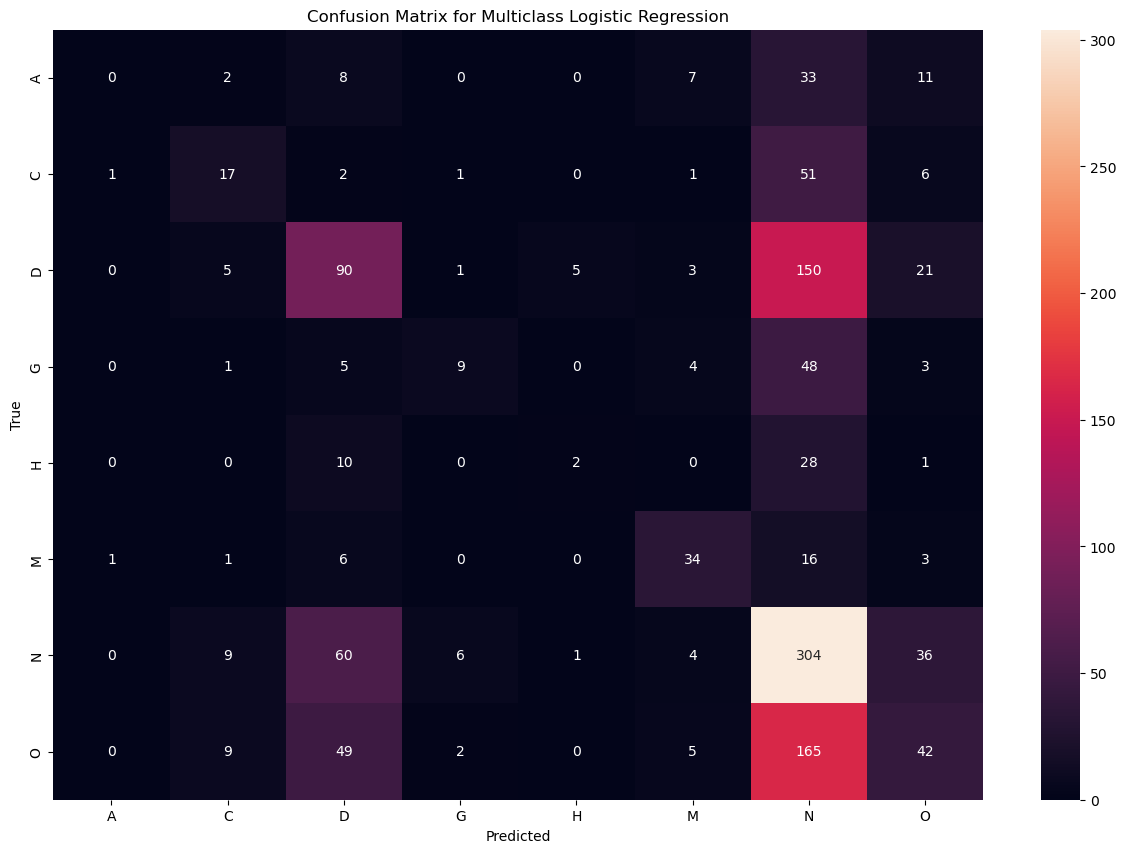

In [143]:
# Confusion Matrix for Logistic Regression Multiclass
cm_multi = confusion_matrix(y_test, y_pred, labels=encoded_indices)
plt.figure(figsize=(15,10))
sns.heatmap(cm_multi, annot=True, fmt='d', xticklabels=encoded_class_labels, yticklabels=encoded_class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Multiclass Logistic Regression')
plt.show()

The predicted and true labels for this model are terrible and will provide a very low baseline for future models. THis would be unacceptable in any context. 
<br> Lets take a look at a confusion matrix for the CNN

40/40 [==============================] - 1s 14ms/step


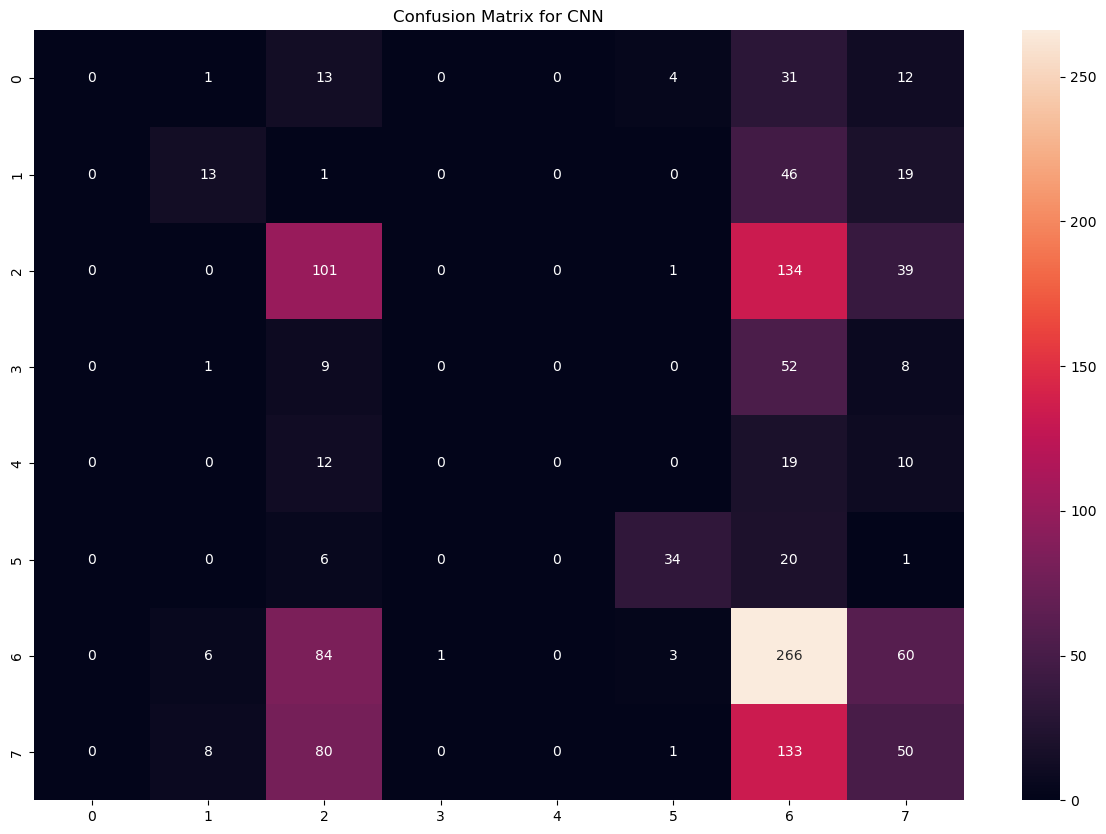

In [144]:
# Confusion Matrix for CNN
cm_cnn = confusion_matrix(np.argmax(y_test_one_hot, axis=1), np.argmax(cnn_model.predict(X_test_cnn), axis=1))
plt.figure(figsize=(15,10))
sns.heatmap(cm_cnn, annot=True, fmt='d')
plt.title('Confusion Matrix for CNN')
plt.show()

Not much better than the linear regression model.

- F1-score, Precision, Recall: Important when classes are imbalanced.




In [103]:
from sklearn.metrics import classification_report

# For Logistic Regression Multiclass
print("Classification Report for Multiclass Logistic Regression:")
print(classification_report(y_test, y_pred))

Classification Report for Multiclass Logistic Regression:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.39      0.22      0.28        79
           2       0.39      0.33      0.36       275
           3       0.47      0.13      0.20        70
           4       0.25      0.05      0.08        41
           5       0.59      0.56      0.57        61
           6       0.38      0.72      0.50       420
           7       0.34      0.15      0.21       272

    accuracy                           0.39      1279
   macro avg       0.35      0.27      0.28      1279
weighted avg       0.37      0.39      0.34      1279



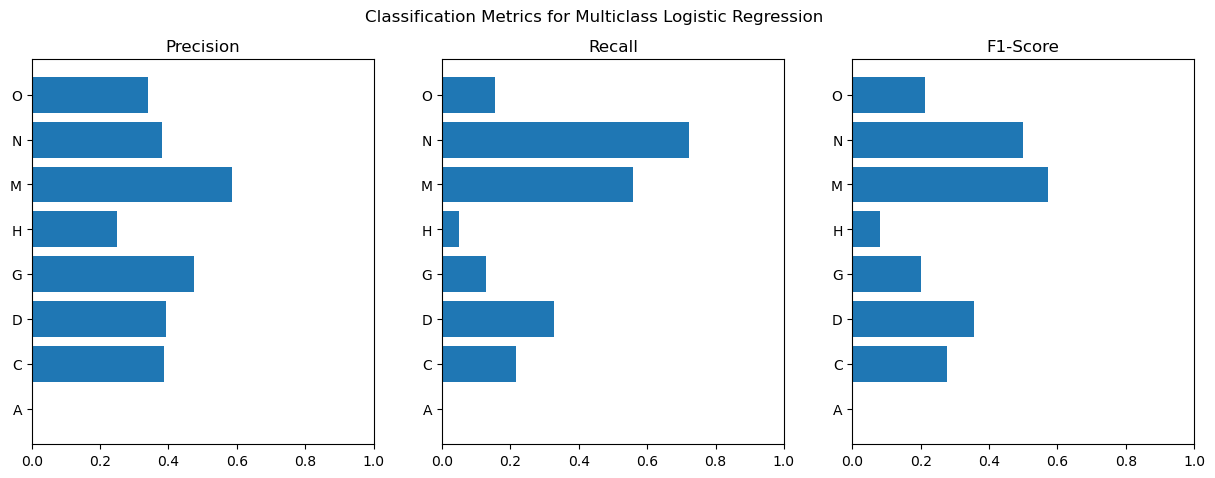

In [104]:
# Inverse transform the encoded labels to original labels
original_labels = label_encoder.inverse_transform(np.unique(y_test))

# Classification Report
report_dict = classification_report(y_test, y_pred, output_dict=True, target_names=original_labels)

# Extract metrics
labels = list(report_dict.keys())[:-3]  # Excluding 'accuracy', 'macro avg', 'weighted avg'
precision = [report_dict[label]['precision'] for label in labels]
recall = [report_dict[label]['recall'] for label in labels]
f1_score = [report_dict[label]['f1-score'] for label in labels]

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot Precision
ax[0].barh(labels, precision)
ax[0].set_title('Precision')
ax[0].set_xlim([0, 1])

# Plot Recall
ax[1].barh(labels, recall)
ax[1].set_title('Recall')
ax[1].set_xlim([0, 1])

# Plot F1-Score
ax[2].barh(labels, f1_score)
ax[2].set_title('F1-Score')
ax[2].set_xlim([0, 1])

plt.suptitle('Classification Metrics for Multiclass Logistic Regression')
plt.show()


Again, this is a bad model and shows that Normal images have the highest recall while Myopia has the highest F1-score with Normal eyes also having a decent balance of precision and recall. 

In [109]:
# For CNN
print("Classification Report for CNN:")
print(classification_report(np.argmax(y_test_one_hot, axis=1), np.argmax(cnn_model.predict(X_test_cnn), axis=1)))

Classification Report for CNN:
40/40 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.46      0.08      0.13        79
           2       0.31      0.21      0.25       275
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        41
           5       1.00      0.15      0.26        61
           6       0.33      0.84      0.48       420
           7       0.38      0.01      0.02       272

    accuracy                           0.34      1279
   macro avg       0.31      0.16      0.14      1279
weighted avg       0.33      0.34      0.24      1279



C:\Users\LiamB\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LiamB\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LiamB\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

40/40 [==============================] - 1s 14ms/step


C:\Users\LiamB\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LiamB\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LiamB\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

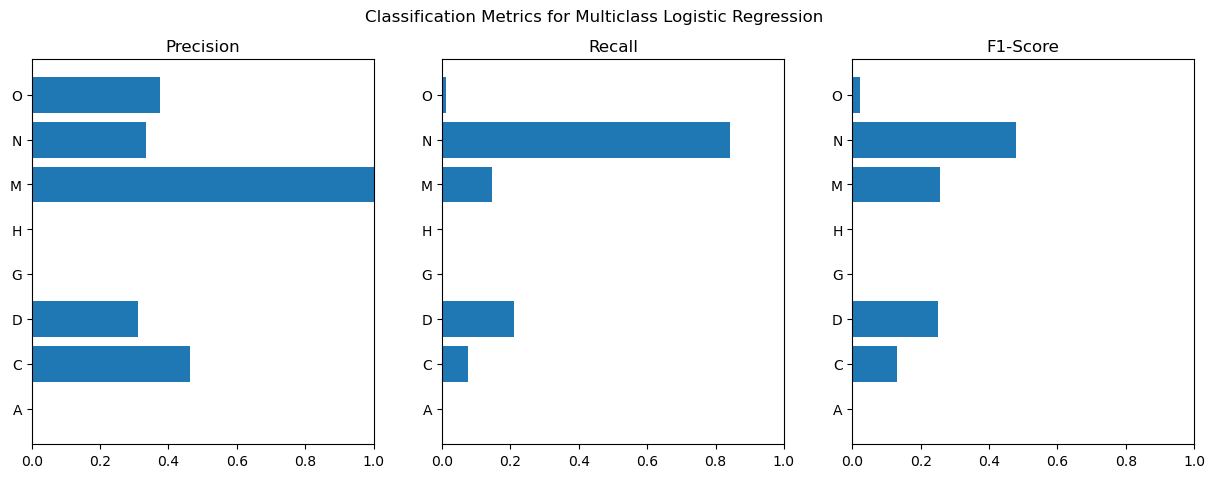

In [110]:
# Inverse transform the encoded labels to original labels
original_labels = label_encoder.inverse_transform(np.unique(y_test))

# Classification Report
report_dict = classification_report(np.argmax(y_test_one_hot, axis=1),np.argmax(cnn_model.predict(X_test_cnn), axis=1), output_dict=True, target_names=original_labels)

# Extract metrics
labels = list(report_dict.keys())[:-3]  # Excluding 'accuracy', 'macro avg', 'weighted avg'
precision = [report_dict[label]['precision'] for label in labels]
recall = [report_dict[label]['recall'] for label in labels]
f1_score = [report_dict[label]['f1-score'] for label in labels]

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot Precision
ax[0].barh(labels, precision)
ax[0].set_title('Precision')
ax[0].set_xlim([0, 1])

# Plot Recall
ax[1].barh(labels, recall)
ax[1].set_title('Recall')
ax[1].set_xlim([0, 1])

# Plot F1-Score
ax[2].barh(labels, f1_score)
ax[2].set_title('F1-Score')
ax[2].set_xlim([0, 1])

plt.suptitle('Classification Metrics for Multiclass Logistic Regression')
plt.show()

This model is even worse than the previous with some of the classes not even being predicted. 

- AUC-ROC for each class: To understand the trade-off between sensitivity and specificity.

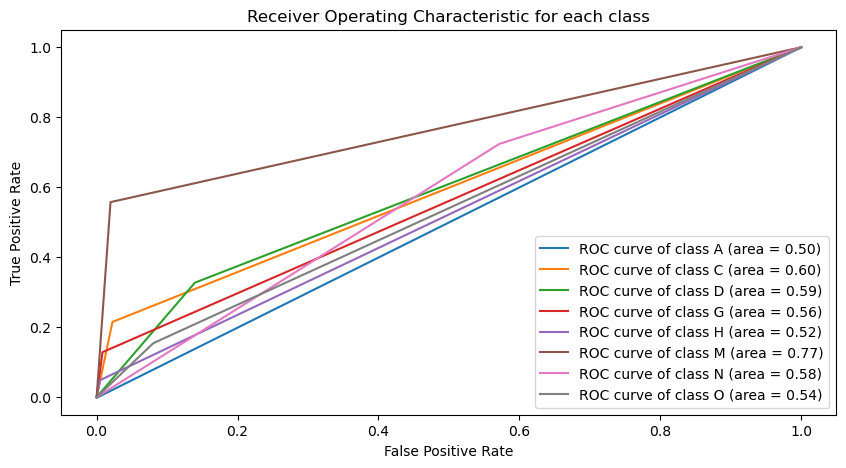

In [138]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

# Get the original class labels from the encoder
original_class_labels = label_encoder.classes_

n_classes = y_test_bin.shape[1]

# Initialize plot
plt.figure(figsize=(10, 5))

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve of class {original_class_labels[i]} (area = {roc_auc:.2f})')

# Title and labels
plt.title('Receiver Operating Characteristic for each class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Legend
plt.legend(loc="lower right")

# Show plot
plt.show()

Justification:
<br>In a medical setting, not all misclassifications have the same cost. Misdiagnosing a severe condition as normal might have a higher cost than misdiagnosing a normal condition as severe.

### Binary Classification (Logistic Regression, Random Forest, CNN)

Metrics:
- Accuracy: To gauge overall effectiveness.

In [118]:
cnn_accuracy =  history.history['val_accuracy'][-1]

print(f'Logistic Regression Accuracy: {accuracy_binary:.2f}%')
print(f'Random Forest Accuracy: {accuracy_rf_binary:.2f}%')
print(f'CNN Accuracy: {cnn_accuracy:.2f}%')

Logistic Regression Accuracy: 0.66%
Random Forest Accuracy: 0.67%
CNN Accuracy: 0.67%


- AUC-ROC: To analyze the trade-off between sensitivity (True Positive Rate) and specificity (True Negative Rate).

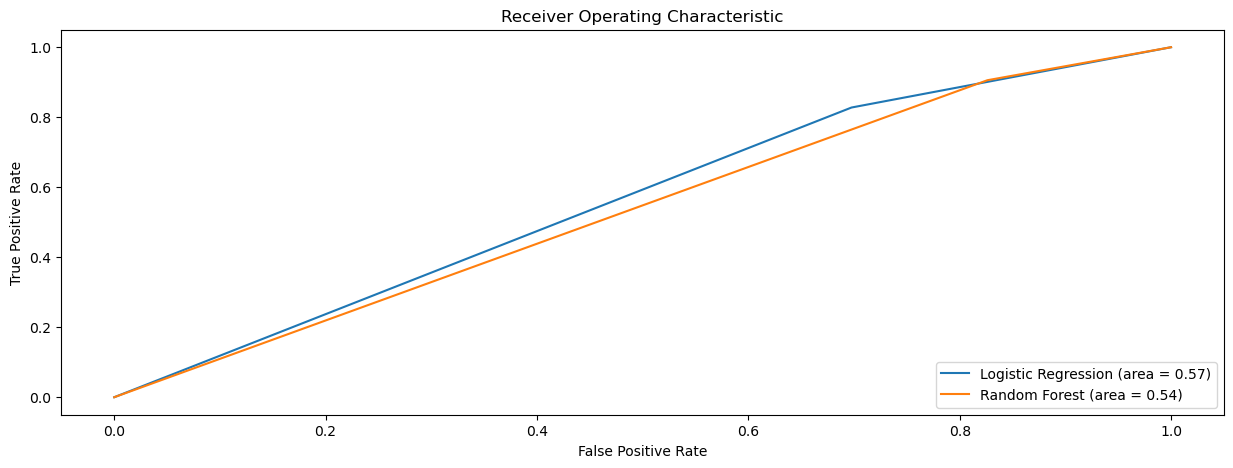

In [133]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test_binary, y_pred_binary)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test_binary, y_pred_rf_binary)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (area = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (area = {roc_auc_rf:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

A ROC_AUC score of 0.57 and 0.54 for Logistic Regression and Random Forest respecively indicate that these models are performing just barely better than a coin flip. Some hyper parameter tuning will have to be done.

- Precision-Recall Curve: Important in the context of imbalanced datasets.

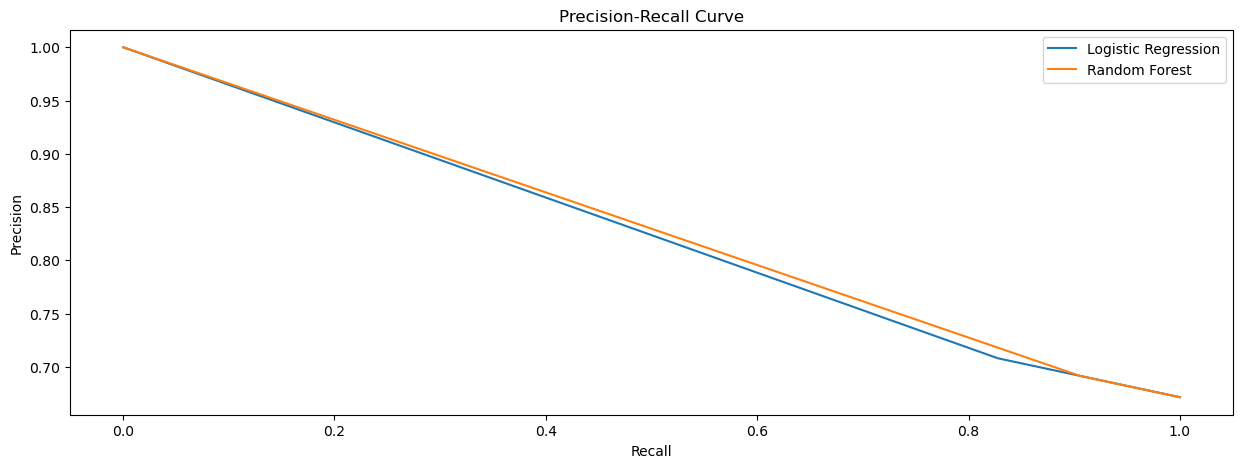

In [140]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Logistic Regression
precision_lr, recall_lr, _ = precision_recall_curve(y_test_binary, y_pred_binary)

# Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test_binary, y_pred_rf_binary)

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(recall_lr, precision_lr, label='Logistic Regression')
plt.plot(recall_rf, precision_rf, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

Precision
- Logistic Regression: The precision for the positive and negative classes are approximately 0.67 and 0.71, respectively.
- Random Forest: Precision for the positive class is approximately 0.67 and for the negative class is approximately 0.69.

Recall
- Logistic Regression: The recall is 1.0 for the positive class and approximately 0.83 for the negative class. While it captures all of the actual positive cases, it misses a significant proportion (about 17%) of the actual negative cases.
- Random Forest: The recall is 1.0 for the positive class and approximately 0.91 for the negative class. This indicates that the RF model captures all of the actual positive cases but misses about 9% of the actual negative cases.

It looks like both models are reasonably balance across precission with Logistic Regresssion performing slight better on the negative class. Both models show high recall for the positive class. This could be beneficial because missing a positive instance has a higher cost than a false positive.

Class Imbalance: The perfect recall score for the positive class in both models likely indicates the class imbalance or that the models are biased towards the positive class.

Justification:
<br>In binary classification for medical diagnosis, a false negative could mean missing a diagnosis (potentially life-threatening), while a false positive could lead to unnecessary tests and anxiety. The cost of these two types of errors might not be the same, hence precision and recall become important.

### Deep Learning (CNN for Binary and Multiclass)

Metrics:
- Validation Loss: To monitor overfitting.

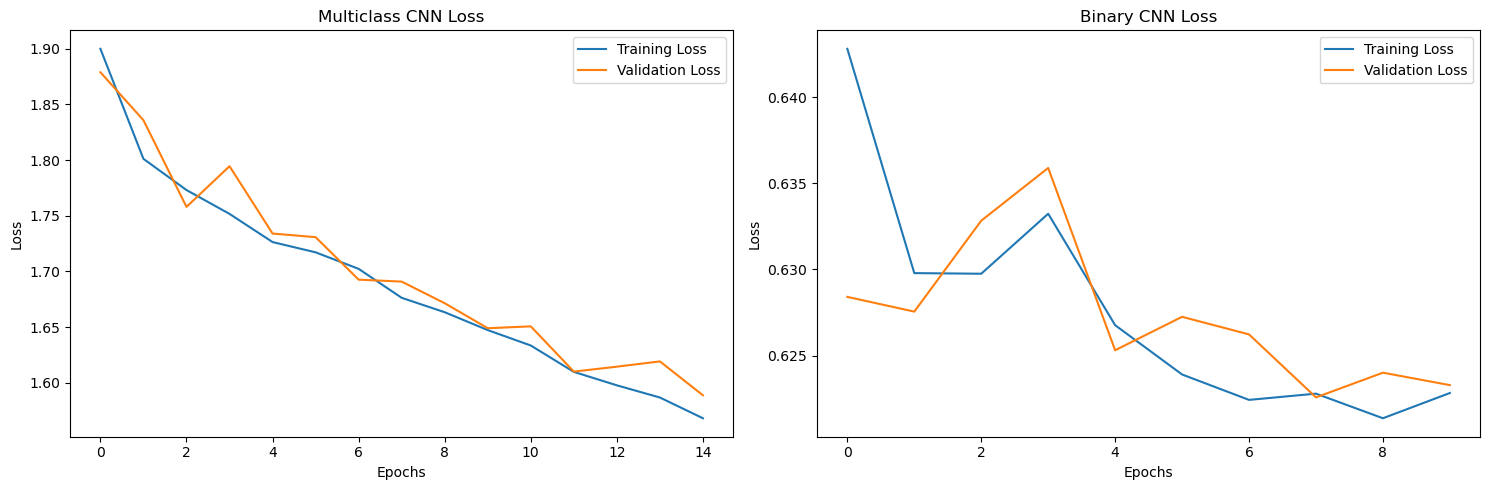

In [136]:
import matplotlib.pyplot as plt

# Plotting loss for multiclass CNN
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_multiclass.history['loss'], label='Training Loss')
plt.plot(history_multiclass.history['val_loss'], label='Validation Loss')
plt.title('Multiclass CNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting loss for binary CNN
plt.subplot(1, 2, 2)
plt.plot(history_binary.history['loss'], label='Training Loss')
plt.plot(history_binary.history['val_loss'], label='Validation Loss')
plt.title('Binary CNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

It doesn't seem lioke either model is overfitting but the model performance for both is quite low. There will be lots of room for improvement for hyperparameter tuning and feature engineering.

Justification:
<br>CNNs can capture spatial hierarchies and are generally good for image data. However, they can easily overfit, so monitoring validation loss is crucial.

## Model Selection 

## Model Training & Tuning 

## Model Interpretation 